# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.


## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#importar las librerias

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [8]:
#importar el dataset

taxi = pd.read_csv('../data/taxi.csv', parse_dates=['datetime'], index_col=[0]) #pasar parse_dates para asegurar  que las fechas estén en el formato adecuado

#visualizar los datos
print(taxi.head(10))
print()
print(taxi.info())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
#asegurarse de que las fechas estén en órden cronológico

taxi.index.is_monotonic_increasing

True

In [5]:
#revisar que no existan valores faltantesz

print(taxi.isnull().sum())


num_orders    0
dtype: int64


Los datos parecen estar listos. No hay valores nulos y están ordenados de manera cronológica, por lo que en la siguiente línea de código se hará el remuestreo por hora, ya que los históricos se muestran en lapsos de 10 minutos.

<Axes: xlabel='datetime'>

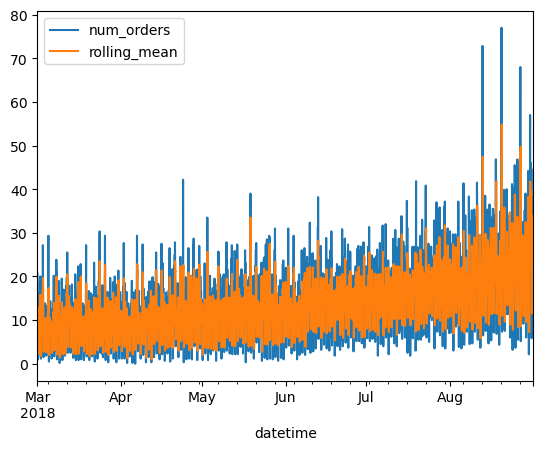

In [6]:
#remuestreo del dataset

resample = taxi.resample('1h').mean()

#añadimos una media móvil para evitar grandes fluctuaciones en los datos

resample['rolling_mean'] = taxi.rolling(20).mean()


#visualización gráfica del remuestreo
resample.plot()

In [7]:
#mostrar una breve estadística de los datos para mejor comprensión de los datos

print(taxi.describe())
print()
print(resample.describe())

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

        num_orders  rolling_mean
count  4416.000000   4412.000000
mean     14.070463     14.101961
std       7.503976      6.218941
min       0.000000      1.000000
25%       9.000000      9.950000
50%      13.000000     13.150000
75%      17.833333     17.350000
max      77.000000     54.850000


## Análisis

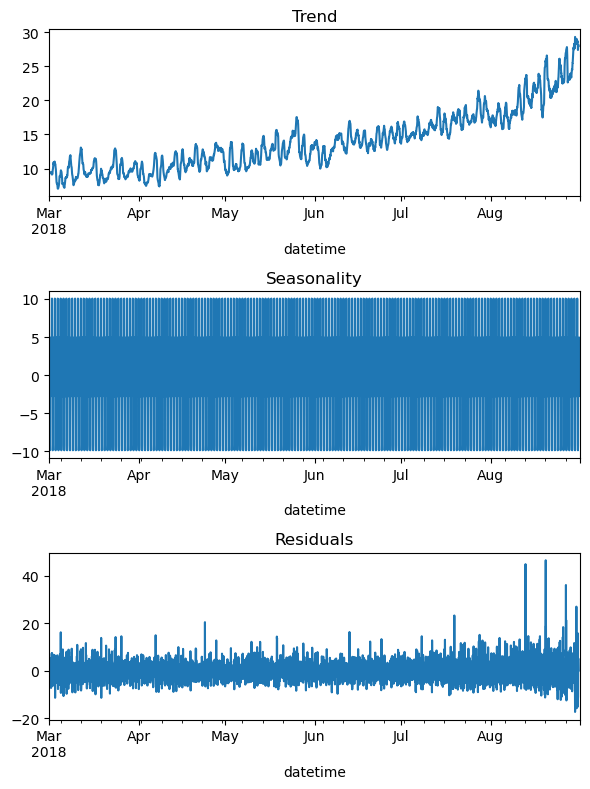

In [8]:
#resampleando los datos y descomponiendo la serie temporal en lapsos de 24 horas

taxi_resamp = taxi.resample('1h').mean()
decompose = seasonal_decompose(taxi_resamp, period=24)

#graficando la estacionalidad y tendencias

plt.figure(figsize=(6, 8))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

- Por la parte de las tenedencias, estas van creciendo en el periodo de marzo a agosto. De igual forma, la tendencia se acelera hacia este último mes. 
- Para la estacionalidad, este gráfico es muy denso, lo cual es indicativo de fluctuaciones cíclicas muy fuertes, es decir, el exceso de ruido no permite determinar patrones claramente.
- Por último, los residuales muestran una variabilidad constante con algunos picos ocasionales. Así como la tendencias, estos comienzan a variar hacia el mes de agosto, indicando un aumento en la demanda de taxis.

Si bien, ya hay una base sólida para entrenar los modelos, se hará una diferenciación de la serie. De esta forma se logrará reducir el ruido que existe en los datos.

<Axes: xlabel='datetime'>

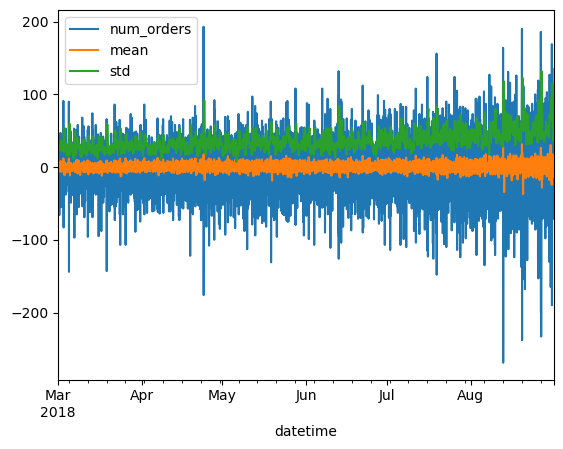

In [9]:
#resampleando los datos 
taxi_diff = taxi.resample('1h').sum()
taxi_diff -= taxi_diff.shift()
taxi_diff['mean'] = taxi_diff['num_orders'].rolling(10).mean()
taxi_diff['std'] = taxi_diff['num_orders'].rolling(10).std()

taxi_diff.plot()



Aún hay periodos con mayor variabilidad, sobreto hacia los meses que ya se ha argumentado, tienen mayor demanda. De manera general, se logró suavizar los datos y mantenerlos relativamente constantes, si bien aún existen ligeras variabilidades en los datos, estos ya se encuentran mejor estado para modelar.

## Formación

In [10]:
#división de los conjuntos de datos

train, test = train_test_split(taxi_diff, test_size=0.1, shuffle=False)

#verificar tamaños
print(f"Tamaño del entrenamiento: {len(train)}")
print(f"Tamaño de la prueba: {len(test)}")

Tamaño del entrenamiento: 3974
Tamaño de la prueba: 442


In [ ]:
#usar RECM para evaluar el conjunto de datos

print('Demanda promedio de taxis:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_median = np.sqrt(mean_squared_error(test, pred_median))
print('RECM:', rmse_median)

print()

#evaluar con el valor anterior de la serie
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_previous = np.sqrt(mean_squared_error(test, pred_previous))
print('RECM (valor anterior):', rmse_previous)

Demanda promedio de taxis: 1.5
RECM: 48.9450223857487

RECM (valor anterior): 54.09435741960025


In [ ]:
#definir una función para agregar 4 nuevas características

def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

#calcular los valores de desfase
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

#calcular la media móvil para después agregarla como característica
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df

taxi_diff_features = make_features(taxi_diff, 7, 30)
taxi_diff_clean = taxi_diff_features.bfill().ffill() #eliminar valores nan
print(taxi_diff_clean.head(8))


                     num_orders  mean        std  year  month  day  dayofweek  \
datetime                                                                        
2018-03-01 00:00:00       -39.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 01:00:00       -39.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 02:00:00       -14.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 03:00:00        -5.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 04:00:00       -23.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 05:00:00       -37.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 06:00:00         6.0  -6.0  23.418891  2018      3    1          3   
2018-03-01 07:00:00         3.0  -6.0  23.418891  2018      3    1          3   

                     lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
datetime                                                               
2018-03-01 00:00:00  -39.0  -39.0  -39.0  -39

In [22]:
#división en train y test ya con los valores nan eliminados
train, test = train_test_split(taxi_diff_clean, test_size=0.1, shuffle=False)

#verificar tamaños
print(f"Tamaño del entrenamiento: {train.shape}")
print(f"Tamaño de la prueba: {test.shape}")

Tamaño del entrenamiento: (3974, 15)
Tamaño de la prueba: (442, 15)


In [25]:
#definiendo características de entrenamiento y prueba

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


## Prueba

In [ ]:
#entrenando un modelo de regresión linear

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

#generando predicciones

pred_train_lr = model_lr.predict(features_train)
pred_test_lr = model_lr.predict(features_test)

#calculando RMSE en entrenamiento
rmse_train = np.sqrt(mean_squared_error(target_train, pred_train_lr))
#calculando RMSE en prueba
rmse_test = np.sqrt(mean_squared_error(target_test, pred_test_lr))

print(f"RMSE en entrenamiento: {rmse_train:.2f}")
print(f"RMSE en prueba: {rmse_test:.2f}")

RMSE en entrenamiento: 25.62
RMSE en prueba: 40.49


In [36]:
#entrenando un modelo de árbol

model_rf = RandomForestRegressor(n_estimators=800, random_state=12345)
model_rf.fit(features_train, target_train)

#generando predicciones

pred_train_rf = model_rf.predict(features_train)
pred_test_rf = model_rf.predict(features_test)

#calculando RMSE en entrenamiendo
rmse_train_rf = np.sqrt(mean_squared_error(target_train, pred_train_rf))

#calculando RMSE en prueba
rmse_test_rf = np.sqrt(mean_squared_error(target_test, pred_test_rf))

print(f"RMSE en entrenamiento: {rmse_train_rf:.2f}")
print(f"RMSE en prueba: {rmse_test_rf:.2f}")

RMSE en entrenamiento: 8.71
RMSE en prueba: 39.68


In [40]:
#entrenando un modelo de regresión gradiente

model_gb = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.12, random_state=12345)
model_gb.fit(features_train, target_train)

#generando predicciones

pred_train_gb = model_gb.predict(features_train)
pred_test_gb = model_gb.predict(features_test)

#calculando RMSE en entrenamiendo
rmse_train_gb = np.sqrt(mean_squared_error(target_train, pred_train_gb))

#calculando RMSE en prueba
rmse_test_gb = np.sqrt(mean_squared_error(target_test, pred_test_gb))

print(f"RMSE en entrenamiento: {rmse_train_gb:.2f}")
print(f"RMSE en prueba: {rmse_test_gb:.2f}")

RMSE en entrenamiento: 10.23
RMSE en prueba: 37.68


In [49]:
#entrenando un modelo de catboost

model_cb = CatBoostRegressor(iterations=2000, learning_rate=0.12)

model_cb.fit(features_train, target_train)


0:	learn: 34.7151170	total: 2ms	remaining: 4s
1:	learn: 33.3951786	total: 2.98ms	remaining: 2.97s
2:	learn: 32.3443912	total: 3.88ms	remaining: 2.58s
3:	learn: 31.4393203	total: 4.93ms	remaining: 2.46s
4:	learn: 30.6028037	total: 6.03ms	remaining: 2.4s
5:	learn: 29.8697208	total: 6.92ms	remaining: 2.3s
6:	learn: 29.2109487	total: 8.61ms	remaining: 2.45s
7:	learn: 28.6281439	total: 9.48ms	remaining: 2.36s
8:	learn: 28.1049547	total: 10.3ms	remaining: 2.29s
9:	learn: 27.6422804	total: 11.3ms	remaining: 2.24s
10:	learn: 27.3258418	total: 12.1ms	remaining: 2.19s
11:	learn: 26.9871289	total: 13.1ms	remaining: 2.17s
12:	learn: 26.7334804	total: 13.9ms	remaining: 2.13s
13:	learn: 26.4732036	total: 15ms	remaining: 2.12s
14:	learn: 26.3269218	total: 15.9ms	remaining: 2.1s
15:	learn: 26.1563754	total: 16.7ms	remaining: 2.07s
16:	learn: 25.9289394	total: 18.1ms	remaining: 2.12s
17:	learn: 25.6642734	total: 19.1ms	remaining: 2.1s
18:	learn: 25.4697635	total: 21.6ms	remaining: 2.25s
19:	learn: 25.3

In [ ]:
#generando predicciones catboost

pred_train_cb = model_cb.predict(features_train)
pred_test_cb = model_cb.predict(features_test)

#calculando RMSE en entrenamiendo
rmse_train_cb = np.sqrt(mean_squared_error(target_train, pred_train_cb))

#calculando RMSE en prueba
rmse_test_cb = np.sqrt(mean_squared_error(target_test, pred_test_cb))

print(f"RMSE en entrenamiento: {rmse_train_cb:.2f}")
print(f"RMSE en prueba: {rmse_test_cb:.2f}")


RMSE en entrenamiento: 3.04
RMSE en prueba: 36.91


In [52]:
#entrenando un modelo LightGBM

lgbm_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=5000,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

lgbm_model.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 13
[LightGBM] [Info] Start training from score -0.011072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that

LGBMRegressor(n_estimators=5000, objective='regression', random_state=42,
              reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

In [ ]:
#generando predicciones LightGBM

pred_train_lgbm = lgbm_model.predict(features_train)
pred_test_lgmb = lgbm_model.predict(features_test)

#calculando RMSE en entrenamiendo
rmse_train_lgbm = np.sqrt(mean_squared_error(target_train, pred_train_lgbm))

#calculando RMSE en prueba
rmse_test_lgbm = np.sqrt(mean_squared_error(target_test, pred_test_lgmb))

print(f"RMSE en entrenamiento: {rmse_train_lgbm:.2f}")
print(f"RMSE en prueba: {rmse_test_lgbm:.2f}")

RMSE en entrenamiento: 0.32
RMSE en prueba: 38.08


## Conclusiones generales

En el proceso de modelado para predecir la cantidad de pedidos de taxis en aeropuertos, se evaluaron diferentes algoritmos con el objetivo de encontrar un equilibrio entre precisión y generalización. Los resultados muestran que algunos modelos, en particular el Random Forest Regressor, presentan un rendimiento sobresaliente en el conjunto de entrenamiento pero un error significativamente mayor en prueba. Esto indica un alto grado de sobreajuste, lo que sugiere que el modelo está aprendiendo patrones específicos de los datos de entrenamiento en lugar de capturar tendencias generales.

Por otro lado, modelos más simples o con regularización aplicada tienden a mostrar una menor varianza y un desempeño más consistente entre entrenamiento y prueba, aunque con un ligero sacrificio en precisión. Esto es clave para aplicaciones en entornos reales, donde la estabilidad del modelo es tan importante como su capacidad predictiva.

En conclusión, aunque algunos modelos muestran un desempeño aceptable, la diferencia en los errores entre entrenamiento y prueba sugiere la necesidad de mejorar la generalización. Un enfoque basado en la combinación de modelos más sofisticados, optimización de hiperparámetros y enriquecimiento de datos podría llevar a un sistema de predicción más preciso y confiable para la toma de decisiones estratégicas en la gestión de la demanda de taxis.